In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential,Model,initializers,layers,Input
from keras.utils.vis_utils import plot_model
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import tensorflow as tf
import numpy as np

(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()

# Normalization
x_train=x_train/255.

x_test=x_test/255.

x_train.shape


x_train = tf.image.resize(x_train, [224,224]) 

x_test = tf.image.resize(x_test, [224,224]) 


In [3]:
y_train = tf.keras.utils.to_categorical(np.array(y_train))
y_test = tf.keras.utils.to_categorical(np.array(y_test))

In [20]:
class google_net(Model):
    def __init__(self):
        super(google_net,self).__init__()

        self.stem=Sequential([   
            layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(7,7),strides=(2,2),padding='same',activation='relu'),
            layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same'),   
            layers.LayerNormalization(),
            layers.Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
            layers.Conv2D(filters=192,kernel_size=(3,3),strides=(2,2),padding='same',activation='relu'),
            layers.LayerNormalization(),
            layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')
        ])

        self.l1=Sequential([
            inception(64,96,128,64,64,64),
            inception(64,96,128,64,64,64),
            layers.MaxPooling2D(pool_size=(1,1),strides=(1,1),padding='same')
        ])
        
        self.l2=Sequential([
            inception(64,96,128,64,64,64),
        ])
        self.l3=Sequential([
            inception(64,96,128,64,64,64),
            inception(64,96,128,64,64,64),
            inception(64,96,128,64,64,64)
        ])
        
        self.l4=Sequential([
            inception(64,96,128,64,64,64),
        ])
        
        self.l5=Sequential([
            layers.MaxPooling2D(pool_size=(1,1),strides=(1,1),padding='same'),
            inception(64,96,128,64,64,64),
            inception(64,96,128,64,64,64),
        ])
 
        self.fclayer=Sequential([
            layers.AveragePooling2D(pool_size=(1,1),strides=(1,1)),
            layers.Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu'),
            layers.Flatten(),
            layers.Dense(units=256,activation='relu'),
            layers.Dropout(0.7),
            layers.Dense(units=10,activation='softmax')
        ])

        self.finalfc=Sequential([
            layers.AveragePooling2D(pool_size=(7,7),strides=(1,1)),
            layers.Flatten(),
            layers.Dense(units=10,activation='softmax')    

        ])

    def call(self,inputs,training=False):
        x=self.stem(inputs,training=training)

        x=self.l1(x,training=False)
        
        x=self.l2(x,training=False)
        ax1=self.fclayer(x,training=False)
        
        x=self.l3(x,training=False)
        ax2=self.fclayer(x,training=False)
        
        x=self.l4(x,training=False)
        
        x=self.l5(x,training=False)
        
        x=self.finalfc(x,training=False)

        return x,ax1,ax2

    def build_graph(self):
        x=Input(shape=(224,224,3))
        return Model(inputs=[x], outputs=self.call(x))

model = google_net()
model.build(input_shape=(None,224,224,3))

In [19]:
class inception(layers.Layer):
        def __init__(self,f1,f2,f3,f4,f5,f6):
                super(inception,self).__init__()

                self.layer1=Sequential([
                        layers.Conv2D(filters=f1,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')
                ])
        
                self.layer2=Sequential([
                        layers.Conv2D(filters=f2,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu'),
                        layers.Conv2D(filters=f3,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')

                ])

                self.layer3=Sequential([
                        layers.Conv2D(filters=f4 ,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu'),
                        layers.Conv2D(filters=f5,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu')
                ])

                
                self.layer4=Sequential([
                        layers.MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same'),
                        layers.Conv2D(filters=f6,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')
                ])

        def call(self,x):
                return tf.concat([self.layer1(x),self.layer2(x),self.layer3(x),self.layer4(x)],axis=3)


In [21]:
model.summary()

Model: "google_net_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_221 (Sequential)  (None, 14, 14, 192)      452736    
                                                                 
 sequential_230 (Sequential)  (None, 14, 14, 320)      574400    
                                                                 
 sequential_235 (Sequential)  (None, 14, 14, 320)      305632    
                                                                 
 sequential_248 (Sequential)  (None, 14, 14, 320)      916896    
                                                                 
 sequential_253 (Sequential)  (None, 14, 14, 320)      305632    
                                                                 
 sequential_262 (Sequential)  (None, 14, 14, 320)      611264    
                                                                 
 sequential_263 (Sequential)  (None, 10)              

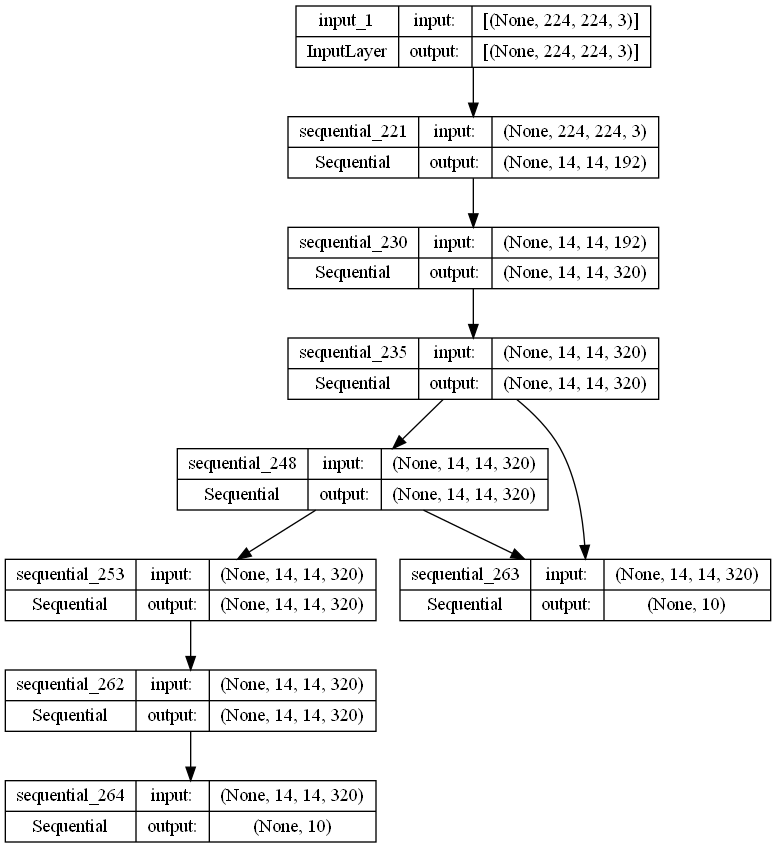

In [22]:
tf.keras.utils.plot_model(
    model.build_graph(),                      # here is the trick (for now)
    to_file='ggsub.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)

In [9]:
#모델만들 때 레이어 이름 지정해주면됨  
model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['acc'],loss_weights={'output_1':1, 'output_2':0., 'output_3':0})

In [10]:
history=model.fit(x_train,{'output_1':y_train,'output_2':y_train,'output_3':y_train},validation_data=(x_test,{'output_1':y_test,'output_2':y_test,'output_3':y_test}),epochs=10,batch_size=8,verbose=1)

Epoch 1/10
5715/6250 [==========================>...] - ETA: 4:30 - loss: 2.3035 - output_1_loss: 2.3035 - output_2_loss: 2.3038 - output_3_loss: 2.3026 - output_1_acc: 0.0997 - output_2_acc: 0.1001 - output_3_acc: 0.0992

KeyboardInterrupt: 